In [ ]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv

In [40]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from io import BytesIO
from PIL import Image
from IPython.display import Markdown

In [41]:
def create_genai_client():
    import os

    # api_key = os.getenv("GOOGLE_API_KEY")
    # if not api_key:
    #     raise ValueError("GOOGLE_API_KEY not found in .env file")
    
    cloud_api_key = os.getenv("GOOGLE_CLOUD_API_KEY")
    if not cloud_api_key:
        raise ValueError("GOOGLE_CLOUD_API_KEY not found in .env file")
    
    # Configure the client with your API key
    # client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})
    client = genai.Client(
        vertexai=True, 
        api_key=cloud_api_key, 
        # http_options={'api_version': 'v1alpha'}
    )

    return client

In [42]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

tools = [types.Tool(google_search=types.GoogleSearch())]

In [ ]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
def print_token_usage(response: types.GenerateContentResponse):
    if response and response.usage_metadata:
        usage_metadata = response.usage_metadata
        input_token_count = usage_metadata.prompt_token_count
        output_token_count = usage_metadata.candidates_token_count
        total_token_count = usage_metadata.total_token_count
        thought_token_count = usage_metadata.thoughts_token_count
        cached_token_count = usage_metadata.cached_content_token_count
        print(f"Input: {input_token_count}, Output: {output_token_count}, Thought: {thought_token_count}, Cached: {cached_token_count} Total: {total_token_count}")
        
def get_num_citations(grounding_supports: list[types.GroundingSupport] | None):
    num_citations = 0
    for support in grounding_supports or []:
        if support.grounding_chunk_indices:
            num_citations = num_citations + len(support.grounding_chunk_indices)

    return num_citations

def build_citations(grounding_supports: list[types.GroundingSupport] | None, grounding_chunks: list[types.GroundingChunk] | None):
    citations: list[str] = []
    for support in grounding_supports:
        if support.grounding_chunk_indices:
            for i in support.grounding_chunk_indices:
                uri = ''
                if grounding_chunks and i < len(grounding_chunks):
                    chunk = grounding_chunks[i]
                    uri = chunk.web.uri if chunk.web and chunk.web.uri else ''
                if uri:
                    citations.append(uri)

    text_citations = "\nCitation link: ".join(citations)
    return "Citation link: " + text_citations

def execute_prompt(prompt: str):
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[types.Content(
            role="user",
            parts=[types.Part(text=prompt)]
        )],
        config=types.GenerateContentConfig(
            tools=tools,
            thinking_config=types.ThinkingConfig(
                thinking_level=types.ThinkingLevel.HIGH
            ),
        )
    )

    print_token_usage(response)
    return response

def print_response(response: types.GenerateContentResponse):
    # print the response
    display(Markdown(f"Response:\n {response.text}"))

    grounding_metadata = response.candidates[0].grounding_metadata if response.candidates and response.candidates[0] and response.candidates[0].grounding_metadata else None
    grounding_chunks = grounding_metadata.grounding_chunks if grounding_metadata and grounding_metadata.grounding_chunks else None
    grounding_supports = grounding_metadata.grounding_supports if grounding_metadata and grounding_metadata.grounding_supports else None
    if grounding_supports and grounding_chunks:
        print (f"{get_num_citations(grounding_supports)} Citations")
        citations = build_citations(grounding_supports=grounding_supports, grounding_chunks=grounding_chunks)
        print(citations)

    web_search_queries = grounding_metadata.web_search_queries if grounding_metadata and grounding_metadata.web_search_queries else None
    if web_search_queries and len(web_search_queries) > 0:
        for query in web_search_queries:
            if query:
                print (f"Query -> {query}")
        
def generate_image(prompt: str, image_config: types.ImageConfig | None = None):
    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=[types.Content(
            role="user",
            parts=[types.Part(text=prompt)]
        )],
        config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE'],
            thinking_config=types.ThinkingConfig(
                include_thoughts=True,
                thinking_budget=512,
            ),
            tools=tools,
            image_config=image_config
        )
    )

    image_bytes: bytes | None = None
    print_token_usage(response)
    if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
        for part in response.candidates[0].content.parts:
            if part.thought and part.text:
                display(Markdown(f"Thought Summary:\n {part.text}"))
            elif part.text:
                print("Text: ", part.text)
            elif part.inline_data:
                image_bytes = part.inline_data.data
       
    return image_bytes

def save_and_show_image(image_bytes: bytes, file_name="./image.png"):
    image = Image.open(BytesIO(image_bytes)) if image_bytes else None
    if image:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        image.save(file_name)

In [45]:
response = execute_prompt(prompt="""
    Please search for the latest confirmed weather forecast for Taiwan for the dates listed below in 2025. specifically looking at Taipei and Taoyuan.
    
    Present the results in a single clear table with the following columns: Date, Location, Weather (Condition, Temp in °C, Precipitation %), and Appropriate Clothing.

    The dates and locations are:
    1. Taipei: November 26, 27, 28, and 29.
    2. Taoyuan: November 30 and December 1.
""")

print_response(response)

Input: 117, Output: 559, Thought: 1092, Cached: None Total: 1768


Response:
 Based on the latest weather forecasts for Taipei and Taoyuan, here is the confirmed weather outlook for late November and early December 2025.

### **Taiwan Weather Forecast (Late Nov - Early Dec 2025)**

| Date | Location | Weather (Condition, Temp in °C, Precipitation %) | Appropriate Clothing |
| :--- | :--- | :--- | :--- |
| **Nov 26** (Wed) | **Taipei** | **Cloudy**, becoming **Light Rain** at night<br>19°C – 22°C<br>Rain Chance: 10% (Day) / 20% (Night) | Long sleeves or light layers; carry a compact umbrella for the evening. |
| **Nov 27** (Thu) | **Taipei** | **Cloudy** throughout the day<br>16°C – 22°C<br>Rain Chance: 35% | Light jacket or sweater; keep an umbrella handy due to moderate rain chance. |
| **Nov 28** (Fri) | **Taipei** | **Mostly Cloudy**, clearing at night<br>16°C – 21°C<br>Rain Chance: 10% | Comfortable layers (t-shirt + cardigan/hoodie); a light jacket for the cooler evening. |
| **Nov 29** (Sat) | **Taipei** | **Sunny** and Clear<br>17°C – 25°C<br>Rain Chance: <10% | T-shirt or light top during the day; bring a light jacket for the temperature drop at night. |
| **Nov 30** (Sun) | **Taoyuan** | **Mostly Sunny** day, Partly Cloudy night<br>18°C – 26°C<br>Rain Chance: 20% (Night) | Breathable clothing for the warmer afternoon; light outerwear for the evening. |
| **Dec 1** (Mon) | **Taoyuan** | **Partly Cloudy**<br>17°C – 24°C<br>Rain Chance: 20% | Standard fall attire (long pants, layers); low risk of rain, but a windbreaker is useful. |

**General Note:** The weather is transitioning to cooler autumn temperatures. While daytime highs are comfortable (low-to-mid 20s), evenings can feel chilly (dropping to 16-17°C). It is advisable to dress in layers to adjust to the temperature difference between day and night.

5 Citations
Citation link: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT77wnEmtAlqbsGH0J7mFhE0B_rDw877AX3x2zJRZ4chJwcuxnA-T2xflkFeplkbxWTwZLtkFcyHl54S1wrk1QrfjPDqCE2mQ8g-r2ygOaqOWmM2RSgIMMjSEGUguhQKYi_3fa9x3LbLkHaA0aEqEHePXArjl0jA==
Citation link: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT77wnEmtAlqbsGH0J7mFhE0B_rDw877AX3x2zJRZ4chJwcuxnA-T2xflkFeplkbxWTwZLtkFcyHl54S1wrk1QrfjPDqCE2mQ8g-r2ygOaqOWmM2RSgIMMjSEGUguhQKYi_3fa9x3LbLkHaA0aEqEHePXArjl0jA==
Citation link: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT77wnEmtAlqbsGH0J7mFhE0B_rDw877AX3x2zJRZ4chJwcuxnA-T2xflkFeplkbxWTwZLtkFcyHl54S1wrk1QrfjPDqCE2mQ8g-r2ygOaqOWmM2RSgIMMjSEGUguhQKYi_3fa9x3LbLkHaA0aEqEHePXArjl0jA==
Citation link: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT77wnEmtAlqbsGH0J7mFhE0B_rDw877AX3x2zJRZ4chJwcuxnA-T2xflkFeplkbxWTwZLtkFcyHl54S1wrk1QrfjPDqCE2mQ8g-r2ygOaqOWmM2RSgIMMjSEGUguhQKYi_3fa9x3LbLkHaA0aEqEHePXArjl0jA==


In [46]:
weather_forecast = response.text
response = execute_prompt(prompt=f"""
    Based on the weather forecast you just retrieved and the itinerary details below, please act as a professional travel planner and generate a comprehensive packing list.

    Trip Itinerary:
    - November 26, 2025 - November 29, 2025: Taipei (City exploration, night markets, extensive walking).
    - November 30, 2025 - December 1, 2025: Taoyuan (Transitioning closer to the airport/coastal area).

    Please categorize the packing list into:

    1. Clothing: Specific recommendations based on the temperature and rain forecast you found. Suggest layers suitable for transitioning between humid outdoor weather, likely rain, and strong indoor air conditioning. Recommend shoes suitable for wet pavement and high daily step counts.
    2. Documents: Entry requirements for Taiwan, digital backups, and essential travel apps.
    3. Financial: Advice on carrying cash (TWD) vs. credit cards, specifically distinguishing between Night Market needs vs. Malls/Department stores.
    4. Electronics: Adapter types (confirm if US plugs work in Taiwan), power banks, and connectivity (eSIM vs. physical SIM).
    5. Essentials: Toiletries, Feminine products and specific items for humid weather. 
    6. Taoyuan Logistics: Any specific tips for moving between Taipei and Taoyuan (e.g., keeping travel documents accessible).
    7. Airport Logistics: Any specific tips for moving between the hotel I am staying in Taoyuan and the airport.

    Special Request: Include a "Taiwan Essentials" section, including the EasyCard (transport card) and specific umbrella recommendations.
    
    Weather forecast:
    {weather_forecast}
    """)

print_response(response)

Input: 918, Output: 1931, Thought: 1451, Cached: None Total: 4300


Response:
 Here is a comprehensive packing list and logistical guide designed specifically for your trip to Taiwan from November 26 to December 1, 2025.

This plan accounts for the moderate "autumn" temperatures (16°C–26°C), the high probability of light rain in Taipei, and the coastal conditions in Taoyuan.

---

### **1. Special Request: Taiwan Essentials**
*Items specific to navigating Taiwan smoothly.*

*   **EasyCard (Yoyo Card) or iPass:**
    *   **Why:** The absolute key to Taiwan travel. Use it for the MRT (subway), buses, convenience stores (7-Eleven/FamilyMart), and even some taxis.
    *   **Action:** Buy one immediately upon arrival at TPE Airport or any MRT station. Load about 1,000 TWD to start.
*   **Compact, Wind-Resistant Umbrella:**
    *   **Why:** The forecast calls for rain on Nov 26-27. Taiwan rain can be sudden, and coastal winds in Taoyuan can invert cheap umbrellas.
    *   **Recommendation:** Bring a high-quality travel umbrella. If you forget, purchase a sturdy clear vinyl umbrella at any 7-Eleven (they are surprisingly durable).
*   **Small Plastic Bags:**
    *   **Why:** Public trash cans are very rare in Taiwan (especially at Night Markets). You will need a place to store your sticky skewers and used napkins until you find a bin (usually at MRT stations or convenience stores).
*   **Hand Sanitizer & Wet Wipes:**
    *   **Why:** Essential for Night Markets (eating finger food) and because some older public restrooms may lack soap or paper towels.

---

### **2. Clothing: The "Onion" Strategy**
*Weather Context: Highs of 25°C (warm) / Lows of 16°C (chilly). Humidity makes the heat feel stickier and the cold feel deeper.*

**Tops (Layers are key):**
*   **3-4 T-shirts/Base Layers:** Breathable cotton or moisture-wicking blends. You will be warm while walking during the sunny days (Nov 29-30).
*   **2 Long-Sleeve Shirts:** For the cooler overcast days (Nov 26-27).
*   **1 Mid-Layer:** A zip-up hoodie, cardigan, or fleece. This is vital for heavily air-conditioned malls/trains and the temperature drop at night.
*   **1 Outer Layer:** A **water-resistant windbreaker** or trench coat.
    *   *Note:* Do not bring a heavy winter down jacket; it will be too hot. A windbreaker over a hoodie is sufficient for 16°C.

**Bottoms:**
*   **2-3 Pairs of Long Pants:** Jeans, chinos, or travel trousers.
*   **1 Pair of Shorts (Optional):** Only for Nov 29/30 if you run hot, as it will be 25°C and sunny. However, long pants are acceptable everywhere.

**Footwear:**
*   **Primary Shoes:** **Water-resistant walking sneakers** or broken-in leather boots.
    *   *Why:* You will log 15,000+ steps a day. Taipei sidewalks can be uneven and slippery when wet (Nov 26 rain). Avoid canvas shoes (Converse/Vans) as they take forever to dry if soaked.
*   **Secondary Shoes:** Comfortable slip-ons for quick hotel lobby runs.

**Sleep & Intimates:**
*   **Pajamas:** Lightweight. Hotels in Taiwan often keep AC very strong, but thick duvet covers are standard.
*   **Socks:** Synthetic/Wool blends to prevent blisters during high step counts.

---

### **3. Documents & Apps**
*   **Entry Requirements:**
    *   **Passport:** Must have at least 6 months of validity remaining.
    *   **Online Arrival Card:** Complete the [ROC Travel Authorization Certificate](https://niaspeedy.immigration.gov.tw/webacard/) online before flying to skip the paper form line at immigration (use the e-Gate if eligible).
*   **Digital Backups:** Save photos of your passport and return flight ticket in Google Drive/iCloud.
*   **Essential Apps:**
    *   **Google Maps:** Highly reliable for MRT and bus schedules.
    *   **Uber:** Widely used in Taipei/Taoyuan.
    *   **Google Translate:** Download the Traditional Chinese language pack for offline use. Use the *Camera* feature to translate menus.
    *   **Line:** The primary communication app in Taiwan (useful if coordinating with local hotels or guides).

---

### **4. Financial: Cash vs. Card**
*   **Currency:** New Taiwan Dollar (TWD).
*   **The Rule:**
    *   **Night Markets / Street Food / Small Bubble Tea Shops:** **CASH IS KING.** They will *not* take credit cards. Carry 100 TWD and 500 TWD bills. Break 1,000 TWD bills at convenience stores; vendors hate breaking large bills for small snacks.
    *   **Malls / Department Stores / Hotels:** Credit Cards (Visa/Mastercard) are accepted everywhere. Apple Pay is widely supported in convenience stores and MRT turnstiles (if using a credit card with foreign transaction enabled).
*   **ATM Advice:** Use ATMs inside 7-Eleven (CTBC Bank) or FamilyMart (Taishin Bank). They work reliably with foreign cards.

---

### **5. Electronics**
*   **Plugs/Adapters:**
    *   **Voltage:** 110V (Same as US/Canada).
    *   **Socket Type:** Type A and B (Two flat pins, sometimes with a ground pin).
    *   **Verdict:** **If you are from the US, you do NOT need an adapter.** Your devices will plug directly into the wall.
*   **Power Bank:** Mandatory. Using maps and taking photos all day drains batteries fast. 10,000mAh recommended.
*   **Connectivity:**
    *   **eSIM (Recommended):** Apps like Airalo or Holafly work perfectly in Taiwan.
    *   **Physical SIM:** Available at TPE Airport arrival hall (Chunghwa Telecom or Taiwan Mobile). Very fast and affordable unlimited data packages.

---

### **6. Essentials & Toiletries**
*   **Toiletries:** Toothbrush/paste (hotels usually provide dental kits, but bring your own just in case).
*   **Feminine Products:** Pads are extremely common in convenience stores. Tampons are harder to find (usually only at drugstores like Watson’s or Cosmed), so bring your own supply if you prefer them.
*   **Humid Weather Aids:**
    *   **Deodorant:** Western-style antiperspirant is hard to find; bring your own.
    *   **Hair Control:** Humidity can cause frizz; bring serum or hair ties.
    *   **Anti-Chafe Balm:** Helpful for high step counts in humid weather.

---

### **7. Logistics: Taipei to Taoyuan (Nov 30)**
*Since you are moving from city exploration to the airport area:*
*   **Luggage Management:** If you plan to explore on the transition day, use **Station Lockers**. Taipei Main Station and Taoyuan HSR station have electronic lockers to store bags while you enjoy your last city hours.
*   **Transport Options:**
    *   **Taxi/Uber:** Door-to-door. Approx 1,000–1,400 TWD. Best if you have heavy luggage.
    *   **HSR (High Speed Rail):** Fastest (20 mins) but drops you at *Taoyuan HSR Station* (not the city center). Good if your Taoyuan hotel is near the Outlet Mall.
    *   **Airport MRT:** Take the "Commuter" (Blue) train if your hotel is in a township between Taipei and the Airport.

---

### **8. Airport Logistics: Taoyuan Hotel to TPE (Dec 1)**
*   **Traffic Warning:** If your flight is during rush hour (8:00 AM – 9:30 AM or 5:00 PM – 7:00 PM), traffic around the airport interchange can be heavy. Allow extra buffer time.
*   **Check-in:** TPE is a busy international hub. Arrive **3 hours before departure**.
*   **Last Minute Shopping:** The airport has excellent shops for Pineapple Cakes (SunnyHills, Chia Te) if you didn't buy them in the city.
*   **Refunds:** If you have a balance remaining on your EasyCard greater than 100 TWD, you can request a refund at the MRT service desk, but usually, it's better to keep it as a souvenir for your next trip

In [ ]:
response = execute_prompt(prompt="""
    Please search the web for my Cathay Pacific flight on November 26, 2025 from Hong Kong to Taipei. The flight number is CX530.
    The departure flight is CX495 on December 1, 2025. 
      
    Present the results in a single clear table with the following columns: Date, From, To, Flight Provider, Flight  Number, Plane Model, Departure, Arrival.
    The From column includes location, airport code, and terminal, in the format of  <Location> (<Code>) - <Terminal>
    Similarly, the To column includes the the same information in the same format."""
)

print_response(response)

In [65]:
image_bytes = generate_image(prompt="""
    Please search for the latest confirmed weather forecast for Taiwan for the dates listed below in 2025. specifically looking at Taipei and Taoyuan.
    The dates and locations are:
    1. Taipei: November 26, 27, 28, and 29.
    2. Taoyuan: November 30 and December 1.
    November has 30 days, so avoid doing weather forecast for November 31.
    Then generate a weather forecast image, add appropriate clothing on each day and in Traditional Chinese.                      
    Do not add persons or background to the image,  just a weather forecast                         
""")
save_and_show_image(image_bytes=image_bytes, file_name='./weather_forecast.png')

RemoteProtocolError: Server disconnected without sending a response.

Input: 272, Output: 1120, Thought: 312, Cached: None Total: 1704


Thought Summary:
 **Designing the Poster**

I'm focused on creating a dynamic travel poster for "TAIPEI 2025." I'm planning to use Google search to gather visual details of specific landmarks. The aim is to blend these details into a montage with different color zones and cinematic lighting.




Thought Summary:
 **Listing Relevant Details**

I'm cataloging the user's specific requests. I've noted the Taipei landmarks, hot springs, and other locations. I've also identified specific named entities mentioned like the book store, logo, and the Hong Kong skyline. The elements are all recorded.




Thought Summary:
 **Confirming Element Availability**

I've verified all the requested elements are present and accounted for. This includes the specified landmarks, the hot springs, the book store, the logo, the skyline, and the wrestling theme. The plan is to create a design that incorporates these elements in a vertical travel poster format, incorporating the city, nature, and action themes.




Thought Summary:
 **Reviewing Image Alignment**

I'm checking the image against the user's detailed request. The image's core design elements are now being assessed for how well they match up with the prompt. Focus is on how effectively the elements have been integrated.




Thought Summary:
 **Evaluating Prompt Compliance**

I'm focused on verifying the image's adherence to the original prompt. The design elements are now under scrutiny. I'm assessing the effectiveness of the integration of the various components, and checking for any mismatches. The aim is to ensure the image meets all stated requirements.




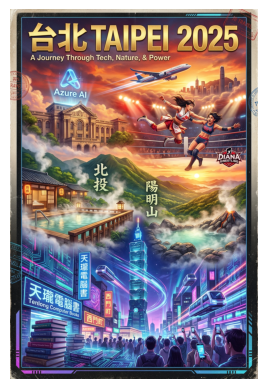

In [ ]:
image_bytes = generate_image(prompt="""
    Please generate a vertical movie-style travel poster titled "TAIPEI 2025" in Traditional Chinese. 
    The composition is a dynamic vertical montage illustrating a journey.
    Please use Google Search tool to find out how the landmarks look like and include them in the poster.

    Visual Elements (blended from bottom to top):
    1. Bottom Section (City & Tech): A bustling street scene featuring "Tenlong Computer Books" and stacks of coding books, merging into the bright neon lights of Ximending and the towering Taipei 101 at night.
    2. Middle Section (Nature & Relax): Steam rising from a traditional Beitou Hot Spring bath set against the lush green backdrop of Yangmingshan mountains.  Please display Beitou and Yangmingshan National Park in Traditional Chinese. 
    3. Top Section (Action & Return): A dynamic female pro-wrestling ring scene (Diana Wrestling) with a flying Japan flag acting as the climax, Azure AI Logo over 臺灣大學社會科學院, with a stylized airplane flying overhead towards a silhouette of the Hong Kong skyline in the clouds.
    4. The female wreslers must look Japanese or Taiwanese.
    
    Style: Vibrant semi-realistic digital art, high saturation, distinct color zones for each location, cinematic lighting, highly detailed.
""", 
image_config=types.ImageConfig(
    aspect_ratio="1:1",
    # image_size="1K"
))
save_and_show_image(image_bytes=image_bytes, file_name='./poster.png')